In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import OrderedDict

from modules import Net, AWNGChannel, BSChannel, RepeatEncoder, RepeatDecoder

R = 2
n_batches = 100
batch_size = 128
n_bits = 4
code_len = R*n_bits

63
191
294
0.9194921875


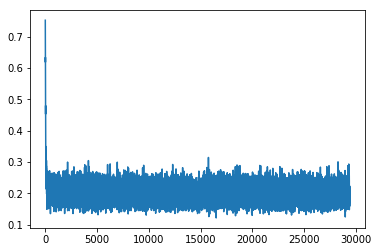

In [25]:
mid_dim = 1024
encoder = Net(n_bits, mid_dim, code_len, 2, 'all', True).cuda()
decoder = Net(code_len, mid_dim, n_bits, 2, 'all', False).cuda()
channel = AWNGChannel(1.0).cuda()
params = [p for p in encoder.parameters()] + [p for p in decoder.parameters()]

n_stops = 0
n_stale_epochs = 0
n_epochs = 0
optimizer = optim.SGD(params, lr=1.0, momentum=0.9, weight_decay=0.0)
losses = []

while n_stops < 3:

    all_data = (torch.rand((n_batches, batch_size, n_bits)) > 0.5).type(torch.FloatTensor)
    n_correct = 0

    for data in all_data:
        optimizer.zero_grad()
        data = Variable(data.cuda())
        message = encoder(data)
        corrupted = channel(message)
        reconstruction = decoder(corrupted)
        loss = F.binary_cross_entropy_with_logits(reconstruction, data)
        loss.backward()
        optimizer.step()

        n_correct += torch.sum(((reconstruction > 0).type(torch.cuda.FloatTensor) == data).type(torch.cuda.FloatTensor))
        losses.append(loss.data[0])
        
    n_epochs += 1
    
    if losses[-n_batches] - np.std(losses[-n_batches:]) < losses[-1]:
        n_stale_epochs += 1
    else:
        n_stale_epochs = 0
        
    if n_stale_epochs > 10:
        n_stale_epochs = 0
        n_stops += 1
        optimizer.param_groups[0]['lr'] *= 0.1
        print n_epochs
    
plt.plot(losses)

print float(n_correct) / all_data.nelement()

In [26]:
binary = lambda x: np.array([int(i) for i in np.binary_repr(x, n_bits)])

data = torch.zeros((2**n_bits, n_bits)).type(torch.FloatTensor)
for i in range(2**n_bits):
    data[i] = torch.from_numpy(binary(i))
    
codes = encoder(Variable(data.cuda())).data
codes[codes > 0] = 1
codes[codes < 0] = 0

In [27]:
data


    0     0     0     0
    0     0     0     1
    0     0     1     0
    0     0     1     1
    0     1     0     0
    0     1     0     1
    0     1     1     0
    0     1     1     1
    1     0     0     0
    1     0     0     1
    1     0     1     0
    1     0     1     1
    1     1     0     0
    1     1     0     1
    1     1     1     0
    1     1     1     1
[torch.FloatTensor of size 16x4]

In [28]:
codes


    0     0     1     0     0     0     1     1
    0     1     1     0     0     1     1     1
    0     0     1     0     1     0     1     0
    0     1     1     0     1     1     1     0
    0     0     1     1     0     0     0     1
    0     1     1     1     0     1     0     1
    0     0     1     1     1     0     0     0
    0     1     1     1     1     1     0     0
    1     0     0     0     0     0     1     1
    1     1     0     0     0     1     1     1
    1     0     0     0     1     0     1     0
    1     1     0     0     1     1     1     0
    1     0     0     1     0     0     0     1
    1     1     0     1     0     1     0     1
    1     0     0     1     1     0     0     0
    1     1     0     1     1     1     0     0
[torch.cuda.FloatTensor of size 16x8 (GPU 0)]